# Code

In [3]:
from commonfunctions import *
from skimage.exposure import histogram
from skimage.measure import find_contours
from skimage.draw import rectangle
from skimage.morphology import binary_opening, binary_erosion, binary_closing, thin
from skimage.filters import gaussian as gaussian_filter
import cv2
%matplotlib inline
%load_ext autoreload
%autoreload 2

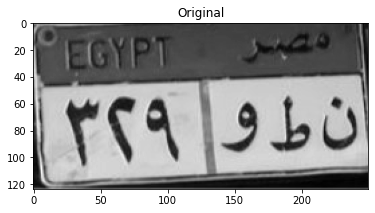

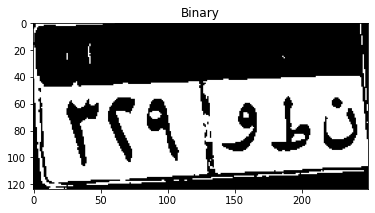

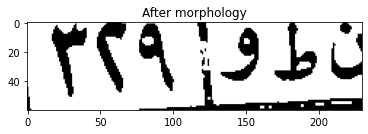

[0.46666667 0.         0.         0.         0.         0.
 0.         0.        ]
10


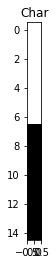

[0.04259095 0.00621118 0.0230701  0.         0.02395741 0.
 0.         0.00177462]
9


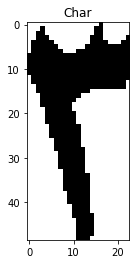

[0.05148741 0.00114416 0.03661327 0.         0.03775744 0.
 0.         0.00114416]
3


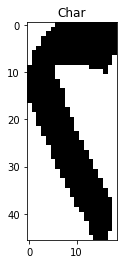

[0.02222222 0.00386473 0.00966184 0.         0.01062802 0.
 0.         0.        ]
29


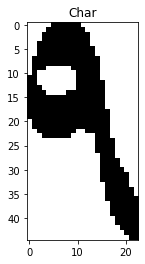

[0.30555556 0.         0.15277778 0.         0.22222222 0.
 0.         0.        ]
10


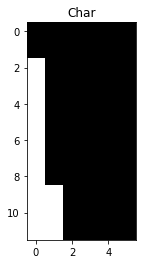

[0.024      0.00228571 0.008      0.         0.00685714 0.
 0.         0.        ]
29


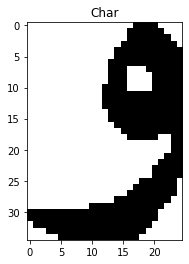

[0.03853383 0.01033835 0.00657895 0.         0.00845865 0.
 0.0018797  0.        ]
29


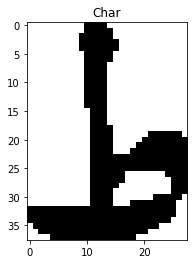

[0.04166667 0.         0.00208333 0.         0.         0.
 0.         0.03125   ]
35


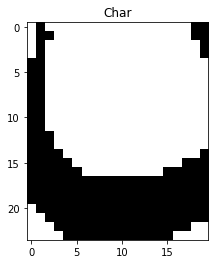

['أ', '9', '3', 'ف', 'أ', 'ف', 'ف', 'ه']


In [41]:
image = (rgb2gray(io.imread("plates_dataset/img4.jpg")) * 255).astype("uint8")
show_images([image], ["Original"])
image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
show_images([image], ["Binary"])
x,y = image.shape
#rightPart = image[int(x//2.2):x-int(x//15),int(y//1.7):y-int(y//20)]
#leftPart = image[int(x//2.2):x-int(x//15),int(y//30):int(y//2)]
image = image[int(x//2.2):x-int(x//15),int(y//30):y-int(y//20)]
#show_images([leftPart, rightPart], ["Binary left part", "Binary right part"])
structuringEl = np.ones((2, 2))        
image = binary_opening(image, structuringEl)
show_images([image], ["After morphology"])
print(getChars(image))

In [40]:
def getAverageError(list1, list2):
    errorList = np.absolute(list1 - list2)
    return (np.average(errorList))

def detectCharText(directions):
    print(directions)
    codes = np.zeros([38, 8]) # 38 char and digit, every one has 8 directions
    codes[1] = np.array([0.15259259, 0, 0.1, 0, 0.01481481, 0, 0, 0])
    codes[2] = np.array([0.08593617, 0.00319149, 0.04585106, 0, 0.04791489, 0, 0.00106383, 0.00412766])
    codes[3] = np.array([0.0431645, 0.002, 0.0341716, 0, 0.03478014, 0, 0.00195858, 0.00287574])
    codes[4] = np.array([0.07024111, 0.02057312, 0.01095257, 0, 0.01595257, 0, 0.002976285, 0.005])
    codes[5] = np.array([0.038602715, 0.03029618, 0.02540032, 0, 0.0242915, 0, 0.019121455, 0.04562266])
    codes[6] = np.array([0.12121212, 0.08712121, 0.03787879, 0, 0.06818182, 0, 0.08333333, 0])
    codes[7] = np.array([0.07012821, 0.008023077, 0.05448718, 0, 0.05769231, 0, 0.00723077, 0.00541026])
    codes[8] = np.array([0.06666667, 0.02016049, 0.003, 0, 0.00872527, 0, 0.00834568, 0.00246914])
    codes[9] = np.array([0.05, 0.01538462, 0.01923077, 0, 0.02307692, 0, 0, 0])
    codes[10] = np.array([0.34827586, 0.01724138, 0.05, 0, 0.08724138, 0, 0, 0.04137931])
    codes[11] = np.array([0.05263158, 0.04174229, 0.03629764, 0, 0.03629764, 0, 0.00181488, 0.00362976])
    codes[14] = np.array([0.00881834, 0.00529101, 0.00116367, 0, 0.00152734, 0, 0.00152734, 0.00176367])
    codes[17] = np.array([0.02, 0.0075, 0.0025, 0, 0.0025, 0, 0.005, 0.0025])
    codes[19] = np.array([0.07179487, 0.06153846, 0, 0, 0.01025641, 0, 0, 0])
    codes[20] = np.array([0.02083333, 0, 0.00520833, 0, 0, 0, 0, 0.01041667])
    codes[21] = np.array([0.03968254, 0.04563492, 0.01984127, 0, 0.01984127, 0, 0.00198413, 0.00396825])
    codes[23] = np.array([0.04830918, 0.04589372, 0.01932367, 0, 0.01932367, 0, 0.00483092, 0.00724638])
    codes[25] = np.array([0.06956522, 0.02028986, 0.0115942, 0, 0.02608696, 0, 0, 0.02318841])
    codes[27] = np.array([0.0739645, 0.01183432, 0.0147929, 0, 0.01775148, 0, 0, 0])
    codes[29] = np.array([0.0297619, 0.00396825, 0.00992063, 0, 0.01190476, 0, 0, 0])
    codes[30] = np.array([0.00941176, 0.00705882, 0.00235294, 0, 0.00470588, 0, 0.00705882, 0])
    codes[32] = np.array([0.05657895, 0.02105263, 0.01710526, 0, 0.01710526, 0.00131579, 0, 0])
    codes[34] = np.array([0.02777778, 0, 0, 0, 0.00396825, 0, 0, 0])
    codes[35] = np.array([0.02783333, 0.00416667, 0.005, 0, 0.005, 0, 0, 0.0125])
    codes[36] = np.array([0.03333333, 0.00333333, 0.01333333, 0, 0.01, 0, 0.00333333, 0.01333333])
    errorAveragesList = np.zeros(38)
    for i in range(0, 38):
        errorAveragesList[i] = getAverageError(directions, codes[i])
    return np.argmin(errorAveragesList) # returns minimum value index

def getFirstPosition(charImage):
    rows, cols = charImage.shape
    startX = 0
    startY = 0
    found = False
    for i in range(0, rows):
        if found == True:
            break
        for j in range(0, cols):
            if(charImage[i][j] == 0):
                startX = i
                startY = j
                found = True
                break
    return startX, startY

def checkRange(i, j, rows, cols):
    return i >=0 and i < rows and j >= 0 and j < cols


def getBlackIndex(currentX, currentY, charImage, isVisited):
    rows, cols = charImage.shape
    neighboursY = [0, -1, -1, -1, 1, 1, 1, 0]
    neighboursX = [1, 0, -1, 1, 0, 1, -1, -1]
    for i in range(0, 8):
        x = currentX + neighboursX[i]
        y = currentY + neighboursY[i]
        if(checkRange(x, y, rows, cols) and (isVisited[x][y] == 0) and (charImage[x][y] == 0)):
            return i, x, y
    return -1, -1, -1

def getDirections(startX, startY, charImage):
    rows, cols = charImage.shape
    directions = np.zeros(8)
    currentX = startX
    currentY = startY
    isVisited = np.zeros([rows, cols])
    isVisited[currentX][currentY] = 1
    while currentX < rows and currentY < cols:
        blackIndex, currentX, currentY = getBlackIndex(currentX, currentY, charImage, isVisited)
        if blackIndex == -1:
            break
        directions[blackIndex] += 1
        isVisited[currentX][currentY] = 1
    normalizedDirections = directions / (rows * cols)
    return normalizedDirections

def detectCharIndex(charImage):
    rows, cols = charImage.shape
    startX, startY = getFirstPosition(charImage)
    directionsCount = getDirections(startX, startY, charImage) # directionsCount = [NS, SN, EW, WE, NSWE, NESW, SENW, SWNE]
    return detectCharText(directionsCount)

def detectChar(index):
    chars = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'أ', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ي']
    print(index)
    return chars[index]

    
def movePointBy90(hieght, width, i, j):
    iNew = -j + width - 1
    jNew = i
    return int(iNew), int(jNew)

def rotateMatrix90(mat):
    image2 = np.zeros([mat.shape[1], mat.shape[0]])
    for i in range(mat.shape[0]-1):
        for j in range(mat.shape[1]-1):
            newPoint = movePointBy90(mat.shape[0], mat.shape[1], i, j)
            image2[newPoint[0], newPoint[1]]=mat[i,j]
    return image2
def rotateMatrixNTimes(mat, n=1):
    for i in range(0, n):
        mat = rotateMatrix90(mat)
    return mat

def getChars(img):
    charTexts = []
    contours = find_contours(img, 0.8)
    with_boxes  = np.zeros(img.shape, dtype=float)
    bounding_boxes = []
    for contour in contours:
        Xmin = int(np.min(contour[:,1]))
        Xmax = int(np.max(contour[:,1]))
        Ymin = int(np.min(contour[:,0]))
        Ymax = int(np.max(contour[:,0]))
        bounding_boxes.append([Xmin, Xmax, Ymin, Ymax])
    bounding_boxes.sort(key=lambda x: x[0])
    for box in bounding_boxes:
        [Xmin, Xmax, Ymin, Ymax] = box
        absWidthDifference = abs(Ymax-Ymin)
        if(absWidthDifference == 0):
            absWidthDifference = 1
        
        if(abs(Xmax-Xmin)/absWidthDifference >= 0.1 and abs(Xmax-Xmin)/absWidthDifference <= 1.9 and abs(Ymax-Ymin) > 12):
            rr, cc = rectangle(start = (Ymin,Xmin), end = (Ymax,Xmax), shape=with_boxes.shape)
            with_boxes[rr, cc] = 1 #set color black
            char = img[rr,cc]
            char = rotateMatrixNTimes(char, 3)
            char = np.fliplr(char)
            rows, cols = char.shape
            char = char[1:rows-1,1:cols-1] # Cancel black borders (thickness is only 1 pixel)
            textCharIndex = detectCharIndex(char)
            textChar = detectChar(textCharIndex)
            charTexts.append(textChar)
            show_images([char], ["Char"])
    #show_images([with_boxes , with_boxes * img], ["With boxes", "show value"])
    return charTexts
